<a href="https://colab.research.google.com/github/flohmannjr/PJI410/blob/main/PJI410_aprendizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PJI410 - Aprendizado

# Importações

In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
# from sklearn.utils import resample

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

SEMENTE  = 2001088 + 2001247 + 2003061 + 2008193 + 2008620 + 2008880

PALETA = 'summer_r'

## Hiperparâmetros TensorFlow

In [3]:
LOTE_TAMANHO = 1024

CAMADAS = 4

CAMADA_UNIDADES      = 50
CAMADA_INICIALIZADOR = 'he_uniform'
CAMADA_ATIVACAO      = 'relu'

SAIDA_UNIDADES = 1
SAIDA_ATIVACAO = 'sigmoid'

PERDA       = 'binary_crossentropy'
OTIMIZADOR  = Adam
APRENDIZADO = 0.001
METRICAS    = ['accuracy']

ITERACOES = 50

## Funções

In [4]:
def avaliar_previsoes(alvos, previsoes):

    print(classification_report(alvos, previsoes))

    ConfusionMatrixDisplay.from_predictions(alvos, previsoes, values_format='d', cmap=PALETA)
    plt.grid(False)

    relatorio = classification_report(alvos, previsoes, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

def obter_conjuntos(dados_treino, dados_validacao, q_modelos=10):

    conjuntos = []

    for m in range(q_modelos):

        modelo = Sequential()

        [modelo.add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO)) for _ in range(CAMADAS)]
        modelo.add(Dense(units=SAIDA_UNIDADES, activation=SAIDA_ATIVACAO))

        modelo.compile(loss=PERDA,
                       optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                       metrics=METRICAS)

        modelo.fit(dados_treino,
                   epochs=ITERACOES,
                   validation_data=dados_validacao,
                   verbose=0)
        
        conjuntos.append(modelo)

    return conjuntos

def obter_previsoes(conjuntos, dados_validacao):
    
    previsoes = []

    for modelo in conjuntos:
        previsoes.append(modelo.predict(dados_validacao, verbose=0))
    
    return tf.constant(tf.squeeze(previsoes))

# Dados

In [5]:
df_sintomas = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_sintomas.zip')

# Aprendizado

## Classificação sobre sintomas e fatores de risco, com EVOLUCAO como atributo alvo

In [32]:
avaliacoes = [None] * 10

### Separação dos dados de treino e teste

In [33]:
X = df_sintomas.drop('EVOLUCAO', axis=1)
y = df_sintomas['EVOLUCAO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE)

In [34]:
# # Rabalancear dados de treino aumentando a amostragem da classe menor.

# treino = pd.concat([X_train, y_train], axis=1)

# obito = treino[treino['EVOLUCAO'] == 0]
# cura  = treino[treino['EVOLUCAO'] == 1]

# obito = resample(obito, replace=True, n_samples=len(cura), random_state=SEMENTE)

# treino = pd.concat([obito, cura])

# y_train = treino['EVOLUCAO']
# X_train = treino.drop('EVOLUCAO', axis=1)

### Modelo 0: SKLearn KNN

In [35]:
%%time

knc = KNeighborsClassifier(n_neighbors=100, weights='uniform', algorithm='auto')

knc.fit(X_train, y_train)

y_pred = knc.predict(X_test)

# param_grid = {'n_neighbors': np.linspace(1, 100, 4, dtype='int'),
#               'weights': ['uniform', 'distance']}

# grid = GridSearchCV(estimator=knc,
#                     param_grid=param_grid,
#                     scoring='accuracy',
#                     cv=10,
#                     verbose=3)

# grid.fit(X_train, y_train)

# print(grid.best_params_)

# y_pred = grid.predict(X_test)

CPU times: user 9min 27s, sys: 2min 12s, total: 11min 39s
Wall time: 10min 5s


              precision    recall  f1-score   support

           0       0.52      0.11      0.19     16995
           1       0.69      0.95      0.80     35986

    accuracy                           0.68     52981
   macro avg       0.61      0.53      0.50     52981
weighted avg       0.64      0.68      0.61     52981



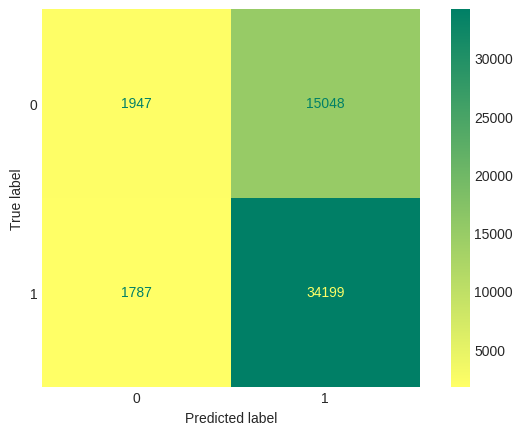

In [36]:
avaliacoes[0] = avaliar_previsoes(y_test, y_pred)

### Modelo 1: SKLearn Decision Tree

In [37]:
%%time

dtc = DecisionTreeClassifier(criterion='gini', splitter='random', max_features=None, random_state=SEMENTE)

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

CPU times: user 2.26 s, sys: 17.7 ms, total: 2.27 s
Wall time: 2.28 s


              precision    recall  f1-score   support

           0       0.42      0.19      0.27     16995
           1       0.70      0.87      0.78     35986

    accuracy                           0.66     52981
   macro avg       0.56      0.53      0.52     52981
weighted avg       0.61      0.66      0.61     52981



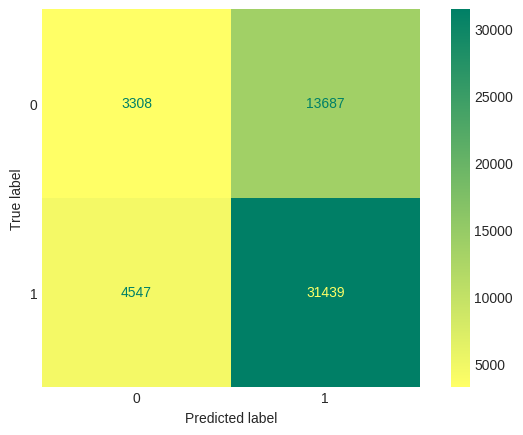

In [38]:
avaliacoes[1] = avaliar_previsoes(y_test, y_pred)

### Modelo 2: SKLearn AdaBoost

In [39]:
%%time

abc = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=SEMENTE)

abc.fit(X_train, y_train)

y_pred = abc.predict(X_test)

CPU times: user 16.6 s, sys: 1.12 s, total: 17.7 s
Wall time: 17.8 s


              precision    recall  f1-score   support

           0       0.53      0.09      0.15     16995
           1       0.69      0.96      0.80     35986

    accuracy                           0.68     52981
   macro avg       0.61      0.53      0.48     52981
weighted avg       0.64      0.68      0.60     52981



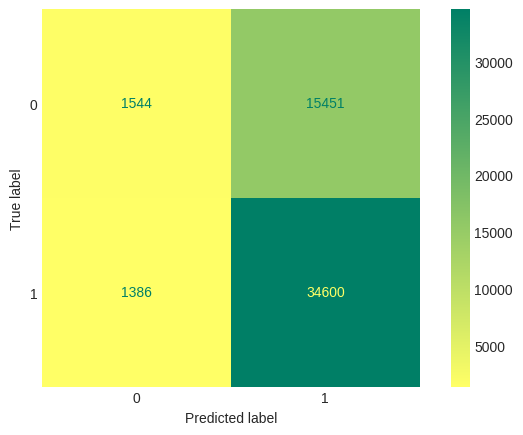

In [40]:
avaliacoes[2] = avaliar_previsoes(y_test, y_pred)

### Modelo 3: SKLearn Gradient Boosting

In [41]:
%%time

gbc = GradientBoostingClassifier(loss='log_loss', n_estimators=50, learning_rate=1.0, criterion='friedman_mse', warm_start=True, max_depth=3, random_state=SEMENTE)

gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)

CPU times: user 29.1 s, sys: 43.9 ms, total: 29.1 s
Wall time: 29.1 s


              precision    recall  f1-score   support

           0       0.54      0.11      0.18     16995
           1       0.69      0.96      0.80     35986

    accuracy                           0.68     52981
   macro avg       0.62      0.53      0.49     52981
weighted avg       0.65      0.68      0.60     52981



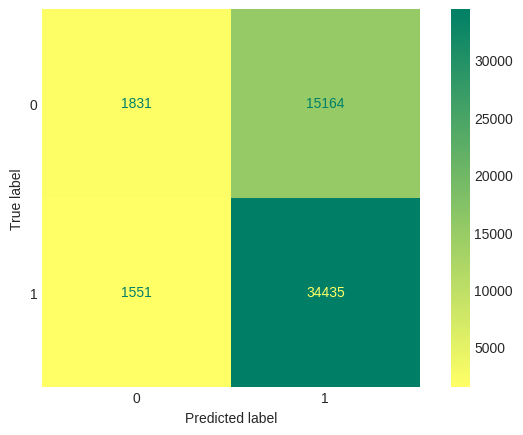

In [42]:
avaliacoes[3] = avaliar_previsoes(y_test, y_pred)

### Datasets

In [43]:
dataset_X_train = Dataset.from_tensor_slices(X_train)
dataset_X_test  = Dataset.from_tensor_slices(X_test)
dataset_y_train = Dataset.from_tensor_slices(y_train)
dataset_y_test  = Dataset.from_tensor_slices(y_test)

dataset_train = Dataset.zip((dataset_X_train, dataset_y_train))
dataset_test  = Dataset.zip((dataset_X_test, dataset_y_test))

dataset_train = dataset_train.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)
dataset_test  = dataset_test.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

### Modelo 4: TensorFlow Dense

In [44]:
%%time

tf.random.set_seed(SEMENTE)

tfd = Sequential()

[tfd.add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO)) for _ in range(CAMADAS)]
tfd.add(Dense(units=SAIDA_UNIDADES, activation=SAIDA_ATIVACAO))

tfd.compile(loss=PERDA,
            optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
            metrics=METRICAS)

tfd.fit(dataset_train,
        epochs=ITERACOES,
        validation_data=dataset_test,
        verbose=0)

y_pred = tf.round(tfd.predict(dataset_test, verbose=0))

CPU times: user 5min 33s, sys: 10.3 s, total: 5min 44s
Wall time: 4min 37s


              precision    recall  f1-score   support

           0       0.51      0.14      0.23     16995
           1       0.70      0.94      0.80     35986

    accuracy                           0.68     52981
   macro avg       0.61      0.54      0.51     52981
weighted avg       0.64      0.68      0.62     52981



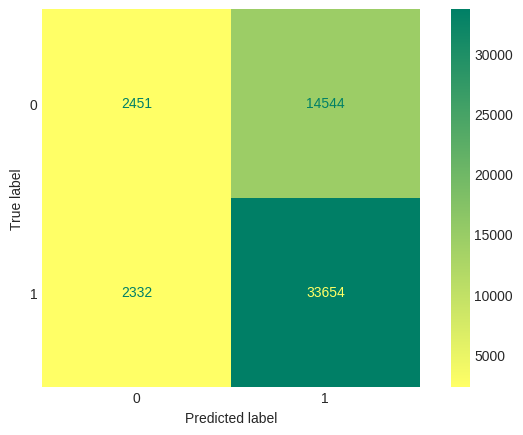

In [45]:
avaliacoes[4] = avaliar_previsoes(y_test, y_pred)

### Modelo 5: TensorFlow Ensemble

In [46]:
%%time

conjuntos = obter_conjuntos(dados_treino=dataset_train, dados_validacao=dataset_test, q_modelos=10)

CPU times: user 55min 45s, sys: 1min 39s, total: 57min 25s
Wall time: 43min 56s


In [47]:
previsoes = obter_previsoes(conjuntos=conjuntos, dados_validacao=dataset_test)

y_pred = tf.round(tf.reduce_mean(previsoes, axis=0))

              precision    recall  f1-score   support

           0       0.53      0.13      0.21     16995
           1       0.70      0.94      0.80     35986

    accuracy                           0.68     52981
   macro avg       0.61      0.54      0.51     52981
weighted avg       0.64      0.68      0.61     52981



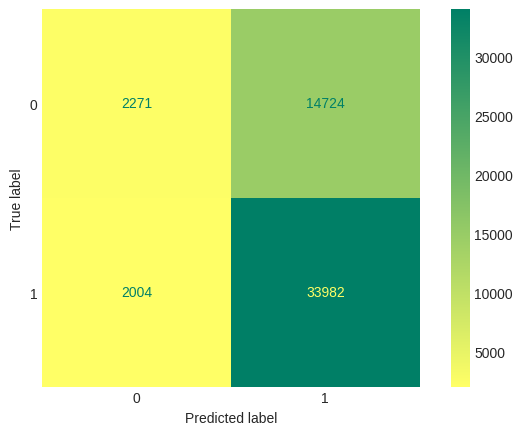

In [48]:
avaliacoes[5] = avaliar_previsoes(y_test, y_pred)

### Comparação de modelos

In [49]:
comparacao = pd.DataFrame([a for a in avaliacoes if a is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

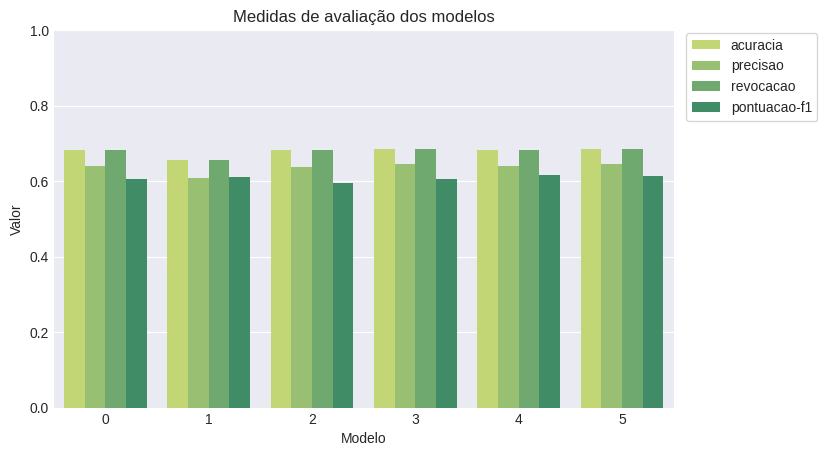

In [50]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette=PALETA)

plt.ylim(0, 1)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelo')
plt.ylabel('Valor')

plt.legend(loc=(1.02, 0.76), frameon=True, facecolor='white');